<a href="https://colab.research.google.com/github/Yustira/ANN-MT-1D/blob/main/Inversion_MT_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install SimPEG==0.11.6
!pip install git+https://github.com/simpeg/tle-magnetotelluric_inversion
!pip install pymatsolver==0.1.3

In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from scipy.constants import mu_0
from SimPEG import (Mesh, Maps, SolverLU, 
                    DataMisfit, Regularization,
                    Optimization, InvProblem, Inversion, 
                    Directives, Utils)
try: 
    from pymatsolver import PardisoSolver as Solver
except importError:
    from SimPEG import SolverLU as SolverLU

from tleMT.MT1D import MT1DProblem, MT1DSurvey, MT1DSrc, ZxyRx, Survey, AppResPhaRx
%matplotlib inline

In [3]:
def open_data(loc_file):
    period = []
    rho = []
    phi = []

    with open(loc_file) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            period.append(float(row[0]))
            rho.append(float(row[1]))
            phi.append(float(row[2]))

    period = np.array(period)
    rho = np.array(rho)
    phi = np.array(phi)
        
    return period, rho, phi

In [4]:
def forecasting(model, series, window_size = 5):
    forecast = []
    for i in range(len(series)-window_size):
        forecast.append(model.predict(series[i:i+window_size][np.newaxis]))
    forecast = np.array(forecast)[:, 0, 0]
    return forecast

In [5]:
def build_mesh(max_depth_core, ncell_per_skind=1e2, 
               n_skind=2, max_hz_core=5e1):
    rxloc = np.r_[0]
    frequency = np.logspace(-4, 4, 10)
    rx = ZxyRx(rxloc, component='both', frequency=frequency)
    src = MT1DSrc([rx])
    survey = MT1DSurvey([src])
    max_depth_core = max_depth_core
    mesh = survey.setMesh(sigma=1e-2, max_depth_core=max_depth_core,
                          ncell_per_skind=ncell_per_skind, n_skind=n_skind, 
                          core_meshType='log', max_hz_core=max_hz_core)
    return mesh, survey

In [6]:
def init_model(mesh, survey, layers_tops, rho_layers):
    prob = MT1DProblem(mesh, sigmaMap=Maps.ExpMap(mesh), 
                       verbose=True, Solver=Solver)
    prob.pair(survey)
    rho = np.ones(mesh.nC)*np.nan
    for layers_top, rho_layer in zip(layers_tops, 
                                     rho_layers):
        inds = mesh.vectorCCx < layers_top
        rho[inds] = rho_layer

    sigma = 1/rho
    z = np.repeat(mesh.vectorCCx[1:], 2, axis=0)
    z = np.r_[mesh.vectorCCx[0], z, mesh.vectorCCx[-1]]
    rho_plt = np.repeat(rho, 2, axis=0)
    return z, rho_plt

In [7]:
def error(var1, var2):
    mae = keras.metrics.mean_absolute_error(var1, var2).numpy()
    mape = keras.metrics.mean_absolute_percentage_error(var1, var2).numpy()
    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(var1, var2)
    rmse = m.result().numpy()
    return mae, mape, rmse

In [8]:
def plot_data(periods, rho, phi, tp):
    fig, ax = plt.subplots(1, 2, figsize=(9*2, 4.5))
    ax[0].loglog(periods, rho, tp, lw=1)    
    ax[0].set_ylabel('$\\rho_a$ $(\\Omega m)$', fontsize=14)
    ax[0].set_title('Apparent Resistivity', fontsize=14)
    ax[0].set_ylim(5e0, 2e3)

    ax[1].semilogx(periods, phi, tp, lw=1)
    ax[1].set_ylabel('$\\phi$ $(^\circ)$', fontsize=14)
    ax[1].set_title('Phase', fontsize=14)
    ax[1].set_ylim([0, 90])

    for a in ax:
        a.set_xlabel('T (s)')
        #a.legend(fontsize=10)
        a.grid(True, which='both', lw=0.5)
        #a.invert_xaxis()
        a.set_xlim([periods.min(), periods.max()])
        
    plt.tight_layout()
    plt.show() 

In [9]:
def fitting(periods, rho_true, rho_forecast, phi_true, phi_forecast, title, window_size=5):
    periods = periods[window_size-3:-window_size+2]
    rho_true = rho_true[window_size-3:-window_size+2]
    phi_true = phi_true[window_size-3:-window_size+2]

    rho_mae, rho_mape, rho_rmse = error(rho_true, rho_forecast)
    phi_mae, phi_mape, phi_rmse = error(phi_true, phi_forecast)

    fig, ax = plt.subplots(2, 1, figsize=(9, 4*2))

    # Apparent resistivity
    ax[0].loglog(periods, rho_true, '.-', lw=2, label='True')
    ax[0].loglog(periods, rho_forecast, '-', color='orange', lw=3, label='Prediction')
    ax[0].set_ylabel('$\\rho_a$ $(\\Omega m)$', fontsize=14)
    ax[0].set_title(title, fontsize=14)
    ax[0].set_ylim(5e0, 2e3)

    # Phase
    ax[1].semilogx(periods, phi_true, '.-', lw=2, label='True')
    ax[1].semilogx(periods, phi_forecast, '-', color='orange', lw=3, label='Prediction')
    ax[1].set_ylabel('$\\phi$ $(^\circ)$', fontsize=14)
    ax[1].set_ylim([0, 90])

    for a in ax:
        a.set_xlabel('T (s)', fontsize=14)
        a.legend(fontsize=10)
        a.grid(True, which='both', lw=0.5)
        a.set_xlim([periods.min(), periods.max()])

    fig.text(0.1, 0.5, 'mae: {:0.2f}/{:0.2f}%'.format(rho_mae, rho_mape), fontsize=12)
    fig.text(0.1, 0.01, 'mae: {:0.2f}/{:0.2f}%'.format(phi_mae, phi_mape), fontsize=12)

    plt.tight_layout()
    plt.show() 

    #print(rho_rmse, phi_rmse)

    return fig

In [10]:
def inv(z, max_depth_core, rho_0, rho_obs, rho_pred, title, loglog=False, window_size=5):
    rho_obs = rho_obs[window_size-3:-window_size+2]
    rho_obs_z = np.repeat(rho_obs, round(len(z)/len(rho_obs)))[::-1]
    rho_pred_z = np.repeat(rho_pred, round(len(z)/len(rho_pred)))[::-1]

    if len(z) > len(rho_obs_z):
        z = z[:len(rho_obs_z)]
        rho_0 = rho_0[:len(rho_obs_z)]
    elif len(z) < len(rho_obs_z):
        rho_obs_z = rho_obs_z[:len(z)]
        rho_pred_z = rho_pred_z[:len(z)]
    else:
        z = z
        rho_0 = rho_0
        rho_obs_z = rho_obs_z
        rho_pred_z = rho_pred_z
    
    rho_mae, rho_mape, rho_rmse = error(rho_obs_z, rho_pred_z)
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 8))
    if loglog == True:
        #ax.loglog(rho_0, -z, '-k', lw=0.8, label='$m_{0}$')
        ax.loglog(rho_obs_z, -z, lw=2.5, label='True')
        ax.loglog(rho_pred_z, -z, lw=2.5, label='Prediction') 
    else:
        #ax.semilogx(rho_0, -z, '-k', lw=0.5, label='$m_{0}$')
        ax.semilogx(rho_obs_z, -z, lw=2.5, label='True')
        ax.semilogx(rho_pred_z, -z, lw=2.5, label='Prediction')

    ax.set_ylim(-1*z.max(), max_depth_core)
    ax.set_xlim(5e0, 2e3)
    ax.set_title(title, fontsize=14)
    ax.set_ylabel("z (m)", fontsize=14)
    ax.set_xlabel('$\\rho_a$ $(\\Omega m)$', fontsize=14)
    ax.invert_yaxis()
    ax.grid(True, which='both', lw=0.4)
    ax.legend(fontsize=10)

    fig.text(0.18, 0.01, 'mae: {:0.2f}/{:0.2f}%'.format(rho_mae, rho_mape), fontsize=12)

    plt.tight_layout()
    plt.show()
    return fig

In [11]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Preparation**

In [12]:
# Load the ANN model
rho_model = tf.keras.models.load_model('/content/gdrive/MyDrive/ANN MT 1D/rho_model.h5')
phi_model = tf.keras.models.load_model('/content/gdrive/MyDrive/ANN MT 1D/phi_model.h5')

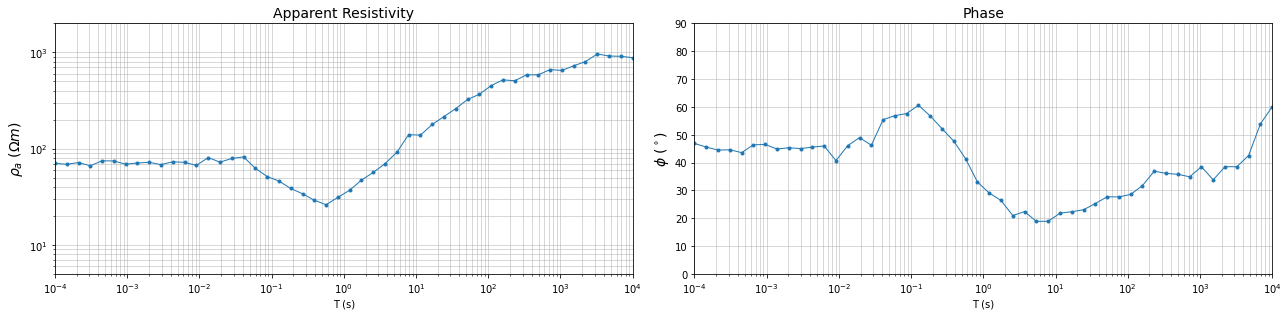

In [25]:
# Load the dataset
loc_file = '/content/gdrive/MyDrive/ANN MT 1D/Data/site10_5.csv'
periods, rho, phi = open_data(loc_file)

# Reverse index array
periods = periods[::-1]
rho_true = rho[::-1]
phi_true = phi[::-1]

plot_data(periods, rho_true, phi_true, '.-')

# **Forecasting**

In [26]:
rho_pred = forecasting(rho_model, rho_true) #predicting apparent resistivity
phi_pred = forecasting(phi_model, phi_true) #predicting phase

# **Inversion**

In [27]:
layers = np.r_[0] # surface
rho_layers = np.r_[0] # initial resistivity on the surface
max_depth_core = 4000 # target depth
mesh, survey = build_mesh(max_depth_core) 
z, rho_0 = init_model(mesh, survey, layers, rho_layers) # creating initial model

>> Smallest cell size = 0 m
>> Padding distance = 1000000 m
>> # of padding cells 33
>> # of core cells cells 371


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


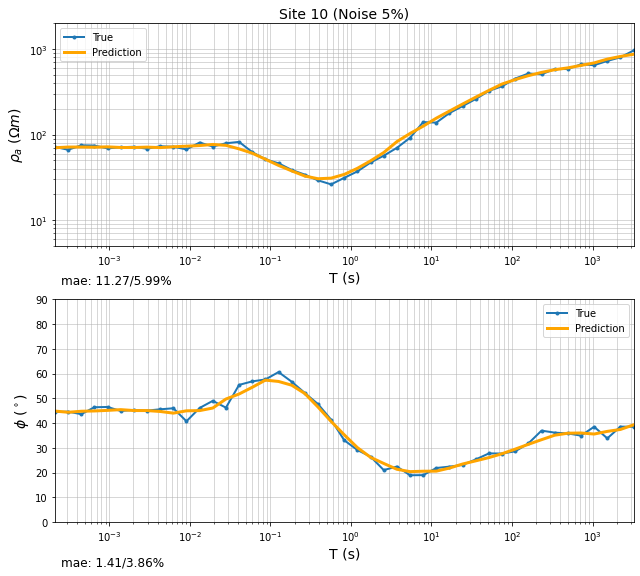

In [28]:
# fitting data between d_true and ANN prediction
name = "Site 10 (Noise 5%)"
fig1 = fitting(periods, rho_true, rho_pred, phi_true, phi_pred, name)

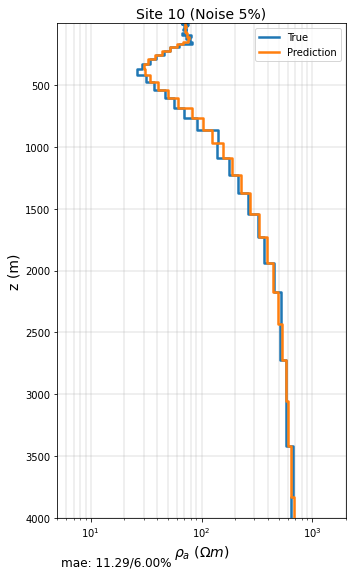

In [29]:
# Inversion
fig2 = inv(z, max_depth_core, rho_0, rho_true, rho_pred, name, loglog=False)

In [30]:
# Saving images
fig1.savefig('Fitting '+name+'.jpg')
fig2.savefig('Inversi '+name+'.jpg')